In [1]:
import gc
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

C:\Users\hdadmin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
path = 'D:\\PythonSamples\\Talking\\'

def timeFeatures(df):
    # Make some new features with click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    #df['dow']      = df['datetime'].dt.dayofweek
    #df["doy"]      = df["datetime"].dt.dayofyear
    df["date_day"]      = df["datetime"].dt.day
    df["date_hour"]      = df["datetime"].dt.hour
    #df["dteom"]    = df["datetime"].dt.daysinmonth - df["datetime"].dt.day
    df.drop(['click_time', 'datetime'], axis=1, inplace=True)
    return df

In [3]:
start_time = time.time()

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

In [4]:
train_ref = pd.read_csv(path+"train.csv", usecols=train_columns, dtype=dtypes)

In [5]:
test_ref = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)

In [6]:
train_ref.describe()

,ip,app,device,os,channel,is_attributed
count,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08
mean,9.087604e+04,1.201131e+01,2.172325e+01,2.267702e+01,2.685789e+02,2.470721e-03
std,6.952789e+04,1.480521e+01,2.593326e+02,5.525282e+01,1.295882e+02,4.964491e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.024500e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.400000e+02,0.000000e+00
50%,7.962200e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.580000e+02,0.000000e+00
75%,1.182470e+05,1.500000e+01,1.000000e+00,1.900000e+01,3.790000e+02,0.000000e+00
max,3.647780e+05,7.680000e+02,4.227000e+03,9.560000e+02,5.000000e+02,1.000000e+00


In [7]:
test_ref.describe()

,click_id,ip,app,device,os,channel
count,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07
mean,9.395234e+06,6.306921e+04,1.221480e+01,1.730513e+00,1.873312e+01,2.648059e+02
std,5.424341e+06,3.688597e+04,1.164924e+01,2.597038e+01,1.135059e+01,1.355254e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.697617e+06,3.155800e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.350000e+02
50%,9.395234e+06,6.393600e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.360000e+02
75%,1.409285e+07,9.531600e+04,1.800000e+01,1.000000e+00,1.900000e+01,4.010000e+02
max,1.879047e+07,1.264130e+05,5.210000e+02,3.031000e+03,6.040000e+02,4.980000e+02


In [8]:
# Drop the IP and the columns from target
train_ref.drop(['is_attributed'], axis=1, inplace=True)
gc.collect()
#nrow_train = train.shape[0]
merge_ref = pd.concat([train_ref, test_ref])
del train_ref, test_ref
gc.collect()

50

In [9]:
#train_ref = timeFeatures(train_ref)

In [10]:
ip_appcount = merge_ref.groupby(['ip']).app.nunique().reset_index()
ip_appcount.columns = ['ip', 'ip_appcounts']

In [11]:
ip_oscount = merge_ref.groupby(['ip']).os.nunique().reset_index()
ip_oscount.columns = ['ip', 'ip_oscounts']

In [12]:
app_ipcount = merge_ref.groupby(['app'])['ip'].count().reset_index()
app_ipcount.columns = ['app', 'app_clickip']

In [13]:
app_app_oscount = merge_ref.groupby(['app','os'])['channel'].count().reset_index()
app_app_oscount.columns = ['app', 'os', 'app_os_clicks']

In [14]:
app_app_devcount = merge_ref.groupby(['app','device'])['channel'].count().reset_index()
app_app_devcount.columns = ['app', 'device', 'app_device_click']

In [15]:
# Count the number of clicks by ip
ip_count = merge_ref.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']

In [16]:
#app_count = merge_ref.groupby(['app'])['channel'].count().reset_index()
#app_count.columns = ['app', 'clicks_by_app']

In [17]:
app_os_dev_count = merge_ref.groupby(['app','os','device'])['channel'].count().reset_index()
app_os_dev_count.columns = ['app','os','device','app_os_dev_count']

In [18]:
del merge_ref
gc.collect()

28

In [19]:
train_rank = pd.read_csv(path+"train.csv") #, usecols=train_columns, dtype=dtypes)

In [20]:
#train_rank.isnull().sum()

In [21]:
#train_rank.head()

In [22]:
apprank = train_rank.groupby(['app'])['is_attributed'].sum().reset_index().astype('int')
apprank.columns = ['app', 'app_sum']

In [23]:
rnk = apprank.loc[apprank['app_sum'] != 0]

In [24]:
rnk['app_rank'] = rnk['app_sum'].rank(ascending=False).astype('int')

C:\Users\hdadmin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
rnk.drop(['app_sum'], axis=1, inplace=True)

C:\Users\hdadmin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
del apprank
del train_rank
gc.collect()

45

In [27]:
train_check_1 = pd.read_csv(path+"train.csv", usecols=train_columns, dtype=dtypes)

In [28]:
test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)

In [29]:
apps = test['app'].unique()

In [30]:
train_check_1 = train_check_1.loc[train_check_1['app'].isin(apps)]

In [31]:
devices = test['device'].unique()

In [32]:
train_check_1 = train_check_1.loc[train_check_1['device'].isin(devices)]

In [33]:
oss = test['os'].unique()

In [34]:
train_check_1 = train_check_1.loc[train_check_1['os'].isin(oss)]

In [35]:
channels = test['channel'].unique()

In [36]:
train_check_1 = train_check_1.loc[train_check_1['channel'].isin(channels)]

In [37]:
train_1 = train_check_1.loc[train_check_1["is_attributed"] == 1]

In [38]:
del apps,devices,oss,channels
gc.collect()

97

In [39]:
#train_check = pd.read_csv(path+"train.csv", skiprows=range(1,127903891), nrows=57000000, usecols=train_columns, dtype=dtypes)
#import random
#train = pd.read_csv(path+"distinct_train.csv", usecols=train_columns, dtype=dtypes, skiprows=lambda i: i>0 and random.random() > fraction_val)                     

In [40]:
train_0 = train_check_1.loc[train_check_1["is_attributed"] == 0]

In [41]:
del train_check_1
gc.collect()

24

In [42]:
part1 = train_0.iloc[0:18490381]
part2 = train_0.iloc[18490381:36980761]
part3 = train_0.iloc[36980761:55471141]
part4 = train_0.iloc[55471141:73961521]
part5 = train_0.iloc[73961521:92451902]
part6 = train_0.iloc[92451901:110942282]
part7 = train_0.iloc[110942282:129432662]
part8 = train_0.iloc[129432662:147923042]
part9 = train_0.iloc[147923042:166413422]
part10 = train_0.iloc[166413422:184903890]

In [43]:
del train_0
gc.collect()

13

In [44]:
part1 = part1.sample(n=100000)
part2 = part2.sample(n=100000)
part3 = part3.sample(n=100000)
part4 = part4.sample(n=100000)
part5 = part5.sample(n=100000)
part6 = part6.sample(n=100000)
part7 = part7.sample(n=100000)
part8 = part8.sample(n=100000)
part9 = part9.sample(n=100000)
part10 = part10.sample(n=100000)

In [45]:
gc.collect()

0

In [46]:
train = pd.concat([train_1, part1, part2, part3, part4, part5, part6, part7, part8, part9, part10])
del  train_1, part1, part2, part3, part4, part5, part6, part7, part8, part9, part10
gc.collect()

0

In [47]:
#train_0 = train_0.tail(57000000)

In [48]:
#del train_check_1
#gc.collect()

In [49]:
#fraction_val = 3000000/57000000
#print(fraction_val)

In [50]:
#train_0f = train_0.sample(frac=fraction_val)

In [51]:
#train = pd.concat([train_1, train_0f])
#del  train_0f, train_1
#gc.collect()

In [52]:
train = train.sample(frac=1).reset_index(drop=True)

In [53]:
# Drop the IP and the columns from target
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)

# Drop IP and ID from test rows
sub = pd.DataFrame()
sub['click_id'] = test['click_id'].astype('int')
#test.drop(['click_id'], axis=1, inplace=True)
#gc.collect()

#nrow_train = train.shape[0]
#merge = pd.concat([train, test])
del test
gc.collect()

42

In [54]:
train = timeFeatures(train)

In [55]:
train = pd.merge(train, ip_appcount, on='ip', how='left', sort=False)
train['ip_appcounts'].fillna(0, inplace=True)
train['ip_appcounts'] = train['ip_appcounts'].astype('uint16')

In [56]:
train = pd.merge(train, ip_oscount, on='ip', how='left', sort=False)
train['ip_oscounts'].fillna(0, inplace=True)
train['ip_oscounts'] = train['ip_oscounts'].astype('uint16')

In [57]:
train = pd.merge(train, app_ipcount, on='app', how='left', sort=False)
train['app_clickip'].fillna(0, inplace=True)
train['app_clickip'] = train['app_clickip'].astype('uint16')

In [58]:
train = pd.merge(train, app_app_oscount, on=['app','os'], how='left', sort=False)
train['app_os_clicks'].fillna(0, inplace=True)
train['app_os_clicks'] = train['app_os_clicks'].astype('uint16')

In [59]:
train = pd.merge(train, app_app_devcount, on=['app','device'], how='left', sort=False)
train['app_device_click'].fillna(0, inplace=True)
train['app_device_click'] = train['app_device_click'].astype('uint16')

In [60]:
train = pd.merge(train, ip_count, on='ip', how='left', sort=False)
train['clicks_by_ip'].fillna(0, inplace=True)
train['clicks_by_ip'] = train['clicks_by_ip'].astype('uint16')

In [61]:
#train = pd.merge(train, app_count, on=['app'], how='left', sort=False)
#train['clicks_by_app'] = train['clicks_by_app'].astype('uint16')

In [62]:
train = pd.merge(train, app_os_dev_count, on=['app','os','device'], how='left', sort=False)
train['app_os_dev_count'].fillna(0, inplace=True)
train['app_os_dev_count'] =train['app_os_dev_count'].astype('uint16')

In [63]:
train = pd.merge(train, rnk, on=['app'], how='left', sort=False)
train['app_rank'].fillna(0, inplace=True)
train['app_rank'] = train['app_rank'].astype('uint16')

In [64]:
train.drop('ip', axis=1, inplace=True)
train.drop('date_day', axis=1, inplace=True)
#train.drop('os', axis=1, inplace=True)
gc.collect()

84

In [65]:
#train.drop('os', axis=1, inplace=True)

In [66]:
import seaborn as sb
%matplotlib inline

In [67]:
train.head()

,app,device,os,channel,date_hour,ip_appcounts,ip_oscounts,app_clickip,app_os_clicks,app_device_click,clicks_by_ip,app_os_dev_count,app_rank
0,12,1,19,326,20,132,114,8542,12172,47068,16902,53250,19
1,23,1,19,153,22,109,110,22839,44020,1534,47421,40992,112
2,20,1,13,259,23,193,138,33445,18452,54810,40368,29471,16
3,10,1,19,377,2,52,44,24588,52695,20011,5982,52154,4
4,3,1,11,409,3,50,43,2444,60257,63603,3813,34563,9


In [68]:
test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)

In [69]:
test = timeFeatures(test)

In [70]:
test = pd.merge(test, ip_appcount, on='ip', how='left', sort=False)
test = pd.merge(test, ip_oscount, on='ip', how='left', sort=False)
test = pd.merge(test, app_ipcount, on='app', how='left', sort=False)
test = pd.merge(test, app_app_oscount, on=['app','os'], how='left', sort=False)
test = pd.merge(test, app_app_devcount, on=['app','device'], how='left', sort=False)
test = pd.merge(test, ip_count, on='ip', how='left', sort=False)
#test = pd.merge(test, app_count, on=['app'], how='left', sort=False)
test = pd.merge(test, app_os_dev_count, on=['app','os','device'], how='left', sort=False)

In [71]:
test['ip_appcounts'].fillna(0, inplace=True)
test['ip_oscounts'].fillna(0, inplace=True)
test['app_clickip'].fillna(0, inplace=True)
test['app_os_clicks'].fillna(0, inplace=True)
test['app_device_click'].fillna(0, inplace=True)
test['clicks_by_ip'].fillna(0, inplace=True)
#test['clicks_by_app'].fillna(0, inplace=True)
test['app_os_dev_count'].fillna(0, inplace=True)

In [72]:
test['ip_appcounts'] = test['ip_appcounts'].astype('uint16')
test['ip_oscounts'] = test['ip_oscounts'].astype('uint16')
test['app_clickip'] = test['app_clickip'].astype('uint16')
test['app_os_clicks'] = test['app_os_clicks'].astype('uint16')
test['app_device_click'] = test['app_device_click'].astype('uint16')
test['clicks_by_ip'] = test['clicks_by_ip'].astype('uint16')
#test['clicks_by_app'] = test['clicks_by_app'].astype('uint16')
test['app_os_dev_count'] = test['app_os_dev_count'].astype('uint16')

In [73]:
test = pd.merge(test, rnk, on=['app'], how='left', sort=False)
test['app_rank'].fillna(0, inplace=True)
test['app_rank'] = test['app_rank'].astype('uint16')

In [74]:
del ip_appcount,app_ipcount,ip_count,app_app_oscount,app_app_devcount
del rnk
gc.collect()

196

In [75]:
test.drop(['click_id', 'ip'], axis=1, inplace=True)
test.drop('date_day', axis=1, inplace=True)

In [76]:
#test.drop('os', axis=1, inplace=True)

In [77]:
#train.drop(['app_clickip','app_os_clicks','app_device_click','clicks_by_ip'], axis=1, inplace=True)
#test.drop(['app_clickip','app_os_clicks','app_device_click','clicks_by_ip'], axis=1, inplace=True)

#train.drop(['channel'], axis=1, inplace=True)
#test.drop(['channel'], axis=1, inplace=True)

In [78]:
#train.drop(['date_hour', 'app_os_dev_count'], axis=1, inplace=True)
#test.drop(['date_hour', 'app_os_dev_count'], axis=1, inplace=True)

In [79]:
#train.drop(['device','app_clickip'], axis=1, inplace=True)
#test.drop(['device','app_clickip'], axis=1, inplace=True)

In [80]:
train.drop(['device','ip_appcounts'], axis=1, inplace=True)
test.drop(['device','ip_appcounts'], axis=1, inplace=True)

In [81]:
test.head()

,app,os,channel,date_hour,ip_oscounts,app_clickip,app_os_clicks,app_device_click,clicks_by_ip,app_os_dev_count,app_rank
0,9,3,107,4,44,62860,28887,44385,1134,14506,6
1,9,3,466,4,67,62860,28887,44385,23273,14506,6
2,21,19,128,4,60,60834,53180,63605,15544,47470,58
3,15,13,111,4,57,64259,64622,59348,12827,16402,17
4,12,13,328,4,33,8542,36788,47068,1441,36875,19


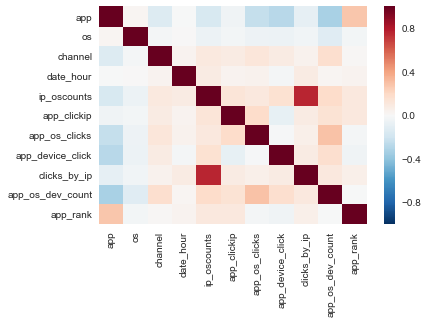

In [82]:
sb.heatmap(train.corr())

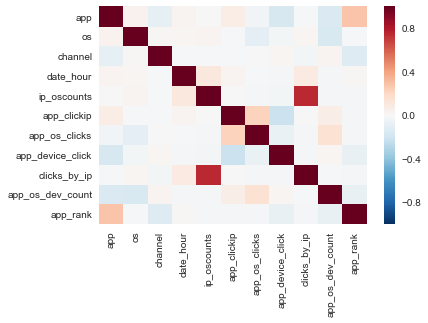

In [83]:
sb.heatmap(test.corr())

In [84]:
test.describe()

,app,os,channel,date_hour,ip_oscounts,app_clickip,app_os_clicks,app_device_click,clicks_by_ip,app_os_dev_count,app_rank
count,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07
mean,1.221480e+01,1.873312e+01,2.648059e+02,9.219946e+00,6.180820e+01,3.648960e+04,3.321143e+04,3.384699e+04,1.197942e+04,3.443016e+04,2.092161e+01
std,1.164924e+01,1.135059e+01,1.355254e+02,3.751926e+00,3.481484e+01,2.365194e+04,1.778136e+04,2.192823e+04,1.400843e+04,1.885363e+04,2.198813e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,1.300000e+01,1.350000e+02,5.000000e+00,4.300000e+01,8.542000e+03,1.795400e+04,1.123100e+04,2.300000e+03,1.741800e+04,9.000000e+00
50%,1.200000e+01,1.800000e+01,2.360000e+02,1.000000e+01,5.500000e+01,4.454300e+04,3.383100e+04,4.438500e+04,6.021000e+03,3.588900e+04,1.200000e+01
75%,1.800000e+01,1.900000e+01,4.010000e+02,1.300000e+01,7.200000e+01,6.083400e+04,4.792400e+04,5.348500e+04,1.707500e+04,5.325000e+04,2.000000e+01
max,5.210000e+02,6.040000e+02,4.980000e+02,1.500000e+01,1.990000e+02,6.429700e+04,6.553400e+04,6.471400e+04,6.471800e+04,6.536100e+04,2.070000e+02


In [85]:
gc.collect()

758

In [86]:
train.describe()

,app,os,channel,date_hour,ip_oscounts,app_clickip,app_os_clicks,app_device_click,clicks_by_ip,app_os_dev_count,app_rank
count,1.452407e+06,1.452407e+06,1.452407e+06,1.452407e+06,1.452407e+06,1.452407e+06,1.452407e+06,1.452407e+06,1.452407e+06,1.452407e+06,1.452407e+06
mean,1.713381e+01,1.902599e+01,2.491856e+02,9.101441e+00,5.336020e+01,2.885798e+04,3.002873e+04,3.116766e+04,1.024507e+04,2.923434e+04,1.683267e+01
std,2.149883e+01,1.155443e+01,1.284466e+02,6.074046e+00,3.688474e+01,2.279913e+04,1.934144e+04,2.169428e+04,1.343970e+04,1.975315e+04,2.028013e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,5.000000e+00,1.300000e+01,1.350000e+02,4.000000e+00,3.300000e+01,3.860000e+03,1.217200e+04,1.235700e+04,1.059000e+03,1.043700e+04,6.000000e+00
50%,1.200000e+01,1.900000e+01,2.340000e+02,9.000000e+00,5.100000e+01,2.468800e+04,3.128900e+04,2.292900e+04,4.477000e+03,2.658800e+04,1.000000e+01
75%,1.900000e+01,2.200000e+01,3.430000e+02,1.300000e+01,6.500000e+01,5.042700e+04,4.586000e+04,4.706800e+04,1.486100e+04,4.755100e+04,1.900000e+01
max,5.020000e+02,5.660000e+02,4.980000e+02,2.300000e+01,1.990000e+02,6.429700e+04,6.553400e+04,6.471400e+04,6.471800e+04,6.536100e+04,2.070000e+02


In [87]:
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import *
from sklearn.grid_search import GridSearchCV

C:\Users\hdadmin\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [88]:
features = list(train.columns) 
print(features)

['app', 'os', 'channel', 'date_hour', 'ip_oscounts', 'app_clickip', 'app_os_clicks', 'app_device_click', 'clicks_by_ip', 'app_os_dev_count', 'app_rank']


In [89]:
for f in train.columns:
    if train[f].dtype=='object':
        #print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

In [90]:
xgb_model = xgb.XGBClassifier()

In [91]:
## Set the params(this params from Pranav kernel) for xgboost model
parameters = {'learning_rate': [0.2,0.3],
          'booster': ["gbtree"],
          'max_depth': [7,8],
          'subsample': [1.0],
          'colsample_bytree': [0.8],    
          'min_child_weight':[0,1,20],
          'reg_alpha':[5.0],
          'gamma':[1.0],
          'objective': ['binary:logistic'], 
          'scale_pos_weight':[1],
          'nthread':[5],
          'random_state': [99], 
          'silent': [1]}

In [92]:
import datetime
datetime.datetime.now()

datetime.datetime(2018, 5, 7, 20, 50, 4, 173989)

In [93]:
clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=StratifiedKFold(y, n_folds=5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

In [94]:
clf.fit(train[features], y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 44.3min
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed: 79.1min finished


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 0 0], n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=5,
       param_grid={'learning_rate': [0.2, 0.3], 'booster': ['gbtree'], 'max_depth': [7, 8], 'subsample': [1.0], 'colsample_bytree': [0.8], 'min_child_weight': [0, 1, 20], 'reg_alpha': [5.0], 'gamma': [1.0], 'objective': ['binary:logistic'], 'scale_pos_weight': [1], 'nthread': [5], 'random_state': [99], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [95]:
datetime.datetime.now()

datetime.datetime(2018, 5, 7, 22, 11, 27, 55138)

In [96]:
#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Raw AUC score: 0.9761115608713805
booster: 'gbtree'
colsample_bytree: 0.8
gamma: 1.0
learning_rate: 0.3
max_depth: 8
min_child_weight: 0
nthread: 5
objective: 'binary:logistic'
random_state: 99
reg_alpha: 5.0
scale_pos_weight: 1
silent: 1
subsample: 1.0


In [97]:
type(clf.best_estimator_.feature_importances_)

numpy.ndarray

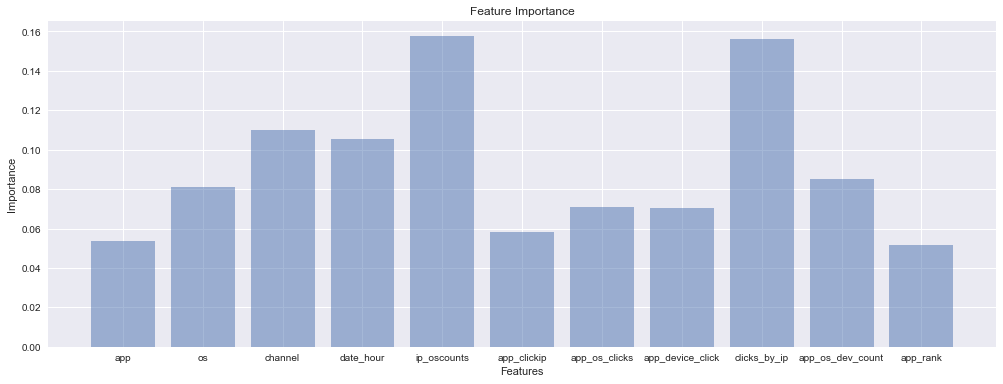

In [98]:
y_pos = np.arange(len(features))
performance = clf.best_estimator_.feature_importances_
plt.figure(figsize=(17,6)) 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, features)
plt.ylabel('Importance')
plt.xlabel('Features')
plt.title('Feature Importance')

In [99]:
test_probs = clf.predict_proba(test[features])[:,1]

In [100]:
sub['is_attributed'] = np.round(test_probs).astype(np.int64)

In [101]:
sub.head()

,click_id,is_attributed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [102]:
sub.to_csv(path+'xgb_sub.csv',index=False)

In [103]:
part1 = 0 - 18490381 
part2 = 18490381 - 36980761
part3 = 36980761 - 55471141
part4 = 55471141 - 73961521
part5 = 73961521 - 92451902
part6 = 92451901 - 110942282
part7 = 110942282 - 129432662
part8 = 129432662 - 147923042
part9 = 147923042 - 166413422
part10 = 166413422 -184903890